In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# The following lines make plots in dark mode look reasonable.  If you are not using dark
# mode you don't need them, but you can also just leave them here and it should work fine.

dark_mode = True
# plotting choices for dark-mode
if (dark_mode):
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
    linecolor = 'w'
else:
    linecolor = 'k'

In [2]:
# Create a Pandas DataFrame with data for calibration of Torsion pendulum

# The data elements are [mass in mg, error in mass in mg, angle in degrees, error in angle in degrees]
calibration_data = [[0, 0.0, 25.5, 0.5], [20, 0.0, 160,0.5], [40, 0.0, 291,0.5], 
                    [50, 0.0, 353.5,0.5], [70, 0.0, 490,0.5], [90, 0.0, 630,0.5]]

# The values in this next line are for the WebWork exercise.
#calibration_data = [[152.9, 0.0, 9.3, 0.0], [448.5, 0.0, 19.3, 0.0], 
#                    [550.5, 0.0, 25.1, 0.0], [560.7, 0.0, 29.8, 0.0], 
#                    [825.7, 0.0, 39.1, 0.0]]

# create dataframe
df = pd.DataFrame(calibration_data, columns = ['Mass_mg', 'dMass_mg', 'Theta_Raw', 'dTheta_Raw'])
df

,Mass_mg,dMass_mg,Theta_Raw,dTheta_Raw
0,0,0.0,25.5,0.5
1,20,0.0,160.0,0.5
2,40,0.0,291.0,0.5
3,50,0.0,353.5,0.5
4,70,0.0,490.0,0.5
5,90,0.0,630.0,0.5


In [3]:
# Calcualate the actual value of theta by subtracting off the angle for Mass=0.  Also, 
# calculate the error in the actual angle using dTheta = dTheta_Raw[i] + dtheta_Raw[0]

offset = df['Theta_Raw'][0]
doffset = df['dTheta_Raw'][0]

# For WebWork
#offset = 0
#doffset = 0

df['Theta'] = df['Theta_Raw'] - offset
df['dTheta'] = df['dTheta_Raw'] + doffset

# Calculate the mass in kg, and the error in the mass in kg
df['Mass'] = df['Mass_mg']*0.000001
df['dMass'] = df['dMass_mg']*0.000001

# Calculate the gravitational Force (and Error) in Newtons
g = 9.81
df['Force'] = df['Mass']*g
df['dForce'] = df['dMass']*g

df

,Mass_mg,dMass_mg,Theta_Raw,dTheta_Raw,Theta,dTheta,Mass,dMass,Force,dForce
0,0,0.0,25.5,0.5,0.0,1.0,0.00000,0.0,0.000000,0.0
1,20,0.0,160.0,0.5,134.5,1.0,0.00002,0.0,0.000196,0.0
2,40,0.0,291.0,0.5,265.5,1.0,0.00004,0.0,0.000392,0.0
3,50,0.0,353.5,0.5,328.0,1.0,0.00005,0.0,0.000490,0.0
4,70,0.0,490.0,0.5,464.5,1.0,0.00007,0.0,0.000687,0.0
5,90,0.0,630.0,0.5,604.5,1.0,0.00009,0.0,0.000883,0.0


# Fitting Stuff

You may have already seen examples of both linear and non-linear regression fits to data.  In most (maybe all?) experiments though, we often have uncertainties associated with each data point.  We should understand more about how this affects the fitting procedure.

The linear/non-linear regression examples that we have studied thus far use a method called "Ordinary Least Squares".  The basic theory behind this is:

$\chi^2 = \sum_i^N (y_i - y_{fit}(x_i))^2$

where $y_{fit} = f(a,b,c,...)$ is the fitting function.  The idea is that we must solve the set of equations defined by:

$\frac{\partial \chi^2}{\partial a} = 0, \frac{\partial \chi^2}{\partial b} = 0, \frac{\partial \chi^2}{\partial c} = 0, ...$

In the case of polynomial fitting functions (of any order), the values of the polynomial coefficients are uniquely defined.  That is, there is a single global minimum in the $\chi^2$ function.  For other non-linear fitting functions, there may be local minima in the $\chi^2$ function, and this requires that we provide initial starting values for the parameters of the fitting function that are close to the global minimum.

When we have uncertainties for each of the $N$ data points, the definition of $\chi^2$ becomes:

$\chi^2 = \sum_i^N \left (\frac{y_i - y_{fit}(x_i)}{\sigma_i}\right)^2$

Now, for this calibration procedure, we have ZERO uncertainty in the y-variable (Mass), and we have some non-zero uncertainty in the x-variable (Angle).  As it turns out, the Ordinary Least Squares procedure can ONLY take into account uncertainties in the y-variable!!!!  This is a actually a significant limitation of this procedure, and we actually should use a more advanced methodology.  However, what we will do for the moment is to simply ignore the errors, and hope that errors in both x and y are manifested in the scatter of the data points themselves.  This is not a totally crazy idea, and in fact it is done quite a lot in the real world.  But, I just wanted to make the point here that there are other, better ways of handling errors in the data points, and you should be aware of that.

# The Fitting Code

The following cell is a very important one!  We will be using this fitting procedure in basically every experiment this semester!!!!

The idea is this:  The first few lines are where we define the data to be fitted.  We need an array of x-values (xi), an array of y-values (yi). We also
include definitions of arrays for the uncertainties in x (sigmaxi) and y (sigmayi).  The error in the Force is zero in this case, and
thus is not considered in the fit, but we include it for plotting purposes.

The lines after that carry out a fairly sophisticated fitting procedure that includes calculation of upper and lower "bands" of the fit corresponding
to the 1-sigma error limits on the fit parameters.  These lines give a nice visual
interpretation of how good the fit is, and whether it captures the variation in the
data.

This code also prints out the final result for the Y = (m +/- dm)X + ( b +/- db) fit.  

*NOTE*:  You might have to change the number of decimal places that are printed out for the final result!!!

Coefficients (from curve_fit)
[2.04450633e-06 1.46713020e-06]
Covariance Matrix (from curve_fit)
[[ 1.53971667e-11 -3.55938083e-14]
 [-3.55938083e-14  1.18844125e-16]]

Final Result: Y = (0.000001467 +/- 0.000000011) X + (0.000002045 +/- 0.000003924)


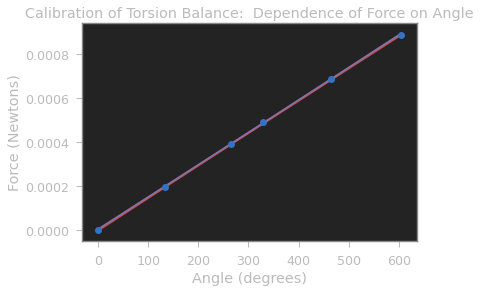

In [4]:
xi = df['Theta']
yi = df['Force']
sigmaxi = df['dTheta']
sigmayi = df['dForce']

##############################

from scipy.optimize import curve_fit

# Define a linear fitting function ... note that we can also use this code to do
# non-linear fitting as well ... we just need to change the function!!!!
def fitfunction(x,*paramlist):
    return paramlist[0]+paramlist[1]*x

# For a linear fit, we have two fit parameters (m,b). Define an array called init_vals
# to hold initial guesses for these two parameters.  As noted above, it does not matter
# what the guesses are for a polynomial fit, but we include it here because (a) the
# curve_fit routine requires it, and (b) it makes it easy to extend this to non-linear
# fitting, where initial guesses are completely necessary.

init_vals = [0.0 for x in range(2)]

# Call the curve_fit routine ... specify the fitting function, the x and y data to be fit
# and the array of initial values.  curve_fit returns an array which contains the 
# optimized fit parameters (popt) and the covariance matrix (pcov).  The covariance
# matrix can be used to extract the uncertainties in the fit parameters (perr).

popt, pcov = curve_fit(fitfunction,xi,yi,p0=init_vals)
perr = np.sqrt(np.diag(pcov))

# The following lines generate upper and lower "Error Bands" on the fit, for visualization
# purposes.

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(xi,*pi) for pi in ps])

lower = np.percentile(ysample,16.0,axis=0)
upper = np.percentile(ysample,84.0,axis=0)
middle = (lower+upper)/2.0

print("Coefficients (from curve_fit)")
print (popt)
print("Covariance Matrix (from curve_fit)")
print (pcov)

print()
print ("Final Result: Y = (%0.9f +/- %0.9f) X + (%0.9f +/- %0.9f)" % (popt[1],perr[1],popt[0],perr[0]))

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='o', capsize=2, capthick=1)

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)

#########################
plt.xlabel('Angle (degrees)')
plt.ylabel('Force (Newtons)')
plt.title('Calibration of Torsion Balance:  Dependence of Force on Angle')
plt.show()

## Analysis of Calibration Result

First of all, we see that this is a very good fit.  The upper and lower error band lines
are visually indistinguishable from one another.  This tells us that we are able to determine the Force for a given angle quite accurately.

Second, we see that the result for the y-intercept (b) is consistent with zero $(2.045 \pm 3.924) \times 10^{-6}$ Newtons.  This is consistent with our expectations.

Third, we see that the calibration constant that we were trying to determine is
$(1.467 \pm 0.011) \times 10^{-6}$ Newtons/degree.  As we said, this is quite well-determined ... the percentage error is $(0.011/1.467)*100\% = 0.75 \%$.

In [5]:
#
# Remember the results of the calibration part of the experiment ... we will use this later, to convert angles into Force values!
#
calibration_factor = popt[1]
dcalibration_factor = perr[1]

In [6]:
# Create a Pandas DataFrame with data for part 1 of the experiment:  understanding the relation of Force to distance, at constant
# charge

# The data elements are [distance in cm, angle in degrees] ... again, since we are going to do a linear regression using OLS, we will
# not include errors
data1 = [[20,15], [20,16.5], [14,45], [14,41], [10,65], [10,72], [9,80], 
         [9,80], [8,105], [8,103], [7,141], [7,140], [6,181], [6,178]]

# create dataframe
df2 = pd.DataFrame(data1, columns = ['R_cm', 'Theta'])
df2

,R_cm,Theta
0,20,15.0
1,20,16.5
2,14,45.0
3,14,41.0
4,10,65.0
5,10,72.0
6,9,80.0
7,9,80.0
8,8,105.0
9,8,103.0


The theory tells us that $F = k \frac{ Q_1  Q_2}{R^2}$.  So, if we were to plot a 
graph of $F$ vs. $\frac{1}{R^2}$, it should be a straight line
with a slope of $k Q_1 Q_2$.  Let's try that!

In [7]:
# We will have to convert the angle values to Forces, and also include an uncertainty.
# We will have to convert the measured radius values to meters, and include an uncertainty.

df2['Force'] = df2['Theta']*calibration_factor
df2['dForce'] = df2['Theta']*dcalibration_factor

df2['R'] = df2['R_cm']*0.01
df2['dR'] = 0.001
df2

,R_cm,Theta,Force,dForce,R,dR
0,20,15.0,0.000022,1.635235e-07,0.20,0.001
1,20,16.5,0.000024,1.798758e-07,0.20,0.001
2,14,45.0,0.000066,4.905704e-07,0.14,0.001
3,14,41.0,0.000060,4.469642e-07,0.14,0.001
4,10,65.0,0.000095,7.086017e-07,0.10,0.001
5,10,72.0,0.000106,7.849127e-07,0.10,0.001
6,9,80.0,0.000117,8.721252e-07,0.09,0.001
7,9,80.0,0.000117,8.721252e-07,0.09,0.001
8,8,105.0,0.000154,1.144664e-06,0.08,0.001
9,8,103.0,0.000151,1.122861e-06,0.08,0.001


Coefficients (from curve_fit)
[-5.45531974e-07  9.97436685e-07]
Covariance Matrix (from curve_fit)
[[ 4.07268201e-12 -5.43399971e-14]
 [-5.43399971e-14  1.37526370e-15]]

Final Result: Y = (0.000000997 +/- 0.000000037) X + (-0.000000546 +/- 0.000002018)


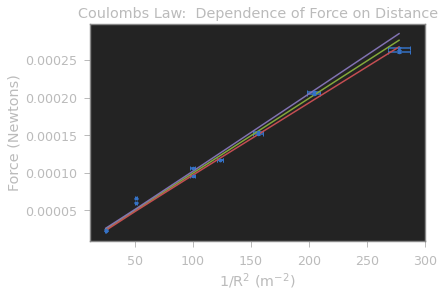

In [8]:
xi = 1.0/(df2['R'])**2
yi = df2['Force']

sigmaxi = xi*2.0*(df2['dR']/df2['R'])
sigmayi = df2['dForce']

##############################

from scipy.optimize import curve_fit

def fitfunction(x,*paramlist):
    return paramlist[0]+paramlist[1]*x

init_vals = [0.0 for x in range(2)]
popt, pcov = curve_fit(fitfunction,xi,yi,p0=init_vals,sigma=sigmayi)
perr = np.sqrt(np.diag(pcov))

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(xi,*pi) for pi in ps])

lower = np.percentile(ysample,16.0,axis=0)
upper = np.percentile(ysample,84.0,axis=0)
middle = (lower+upper)/2.0

print("Coefficients (from curve_fit)")
print (popt)
print("Covariance Matrix (from curve_fit)")
print (pcov)

print()
print ("Final Result: Y = (%0.9f +/- %0.9f) X + (%0.9f +/- %0.9f)" % (popt[1],perr[1],popt[0],perr[0]))

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='.', capsize=2, capthick=1)

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)

#########################
plt.xlabel('1/R$^2$ (m$^{-2})$')
plt.ylabel('Force (Newtons)')
plt.title('Coulombs Law:  Dependence of Force on Distance')
plt.show()

## Preliminary observations 

So, our first observation is that indeed, the plot seems roughly linear, as we expected!  This means that our guess for the form of the force law was probably correct!  

However, there are some issues that we need to think about, as well.  One major issue here is that the error in the x-values is much larger than the error in the y-values. 

As noted above, Ordinary Least Squares only considers errors in the y-values.  This is
a problem for us, and we need to consider how to handle it.

One method (in fact, the best method) is to use a different and more advanced fitting
procedure that takes into account errors in both the x and y data.  Another, simpler method, though, which will work well here, is to just reverse the roles of x and y in our plot.  That is, we should plot instead $\frac{1}{R^2}$ vs. $F$!!!  Then, the larger
errors will be in the y-direction, as we would wish.  If we do things this way, we would expect a straight line with a slope of $\frac{1}{k Q_1 Q_2}$.

Coefficients (from curve_fit)
[3.90576316e+00 8.84823826e+05]
Covariance Matrix (from curve_fit)
[[ 3.93862815e+00 -8.99214695e+04]
 [-8.99214695e+04  3.01286940e+09]]

Final Result: Y = (884823.825937309 +/- 54889.610999988) X + (3.905763155 +/- 1.984597729)


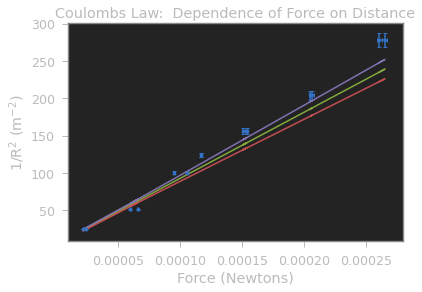

In [9]:
# Here, I have just copied the code from above and reversed x and y.

yi = 1.0/(df2['R'])**2
xi = df2['Force']

sigmayi = yi*2.0*(df2['dR']/df2['R'])
sigmaxi = df2['dForce']

##############################

from scipy.optimize import curve_fit

def fitfunction(x,*paramlist):
    return paramlist[0]+paramlist[1]*x

init_vals = [0.0 for x in range(2)]
popt, pcov = curve_fit(fitfunction,xi,yi,p0=init_vals,sigma=sigmayi)
perr = np.sqrt(np.diag(pcov))

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(xi,*pi) for pi in ps])

lower = np.percentile(ysample,16.0,axis=0)
upper = np.percentile(ysample,84.0,axis=0)
middle = (lower+upper)/2.0

print("Coefficients (from curve_fit)")
print (popt)
print("Covariance Matrix (from curve_fit)")
print (pcov)

print()
print ("Final Result: Y = (%0.9f +/- %0.9f) X + (%0.9f +/- %0.9f)" % (popt[1],perr[1],popt[0],perr[0]))

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='.', capsize=2, capthick=1)

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)

#########################
plt.ylabel('1/R$^2$ (m$^{-2})$')
plt.xlabel('Force (Newtons)')
plt.title('Coulombs Law:  Dependence of Force on Distance')
plt.show()

We know that the slope is supposed to be $\frac{1}{k Q_1 Q_2}$.  So, what are $Q_1$ and $Q_2$?  According to the same theory, they should be
equal to one another, and be related to the applied voltage, V, according to:

$Q = \frac{R_{sphere}}{k} V$

Substituting this into our experession for the slope, we get:

$\frac{1}{slope} = k  \left( \frac{R_{sphere}}{k} V \right) \left( \frac{R_{sphere}}{k}V \right) = \frac{R_{sphere}^2 V^2}{k}$

$k = R_{sphere}^2 V^2 \times slope$

We used $V = 6.00~kV = 6000~V$.
We are told that $R_{sphere} = 1.9~cm = 0.019~m$.

But, there are uncertainties in both of these numbers:

$dV = 10~Volts + (0.01)V = 10~Volts + 0.01(6000 V) = 70~Volts$.

$dR_{sphere} = 0.1~cm = 0.001~m$.

From basic error analysis, we get that $\frac{dk}{k} = 2 \frac{dR_{sphere}}{R_{sphere}} + 2\frac{dV}{V} + \frac{dslope}{slope}$

In [10]:
#
# Now, let us see if we can calculate what k is, based on the slope from the previous graph
#

slope = popt[1]
dslope = perr[1]

V = 6000
dV = 10 + 0.01*V
R_sphere = 0.019
dR_sphere = 0.001

k = R_sphere**2*V**2*slope
dk = k*(2*dR_sphere/R_sphere+2*dV/V+dslope/slope)

print ('Extracted value of k = (%0.1f +/- %0.1f) x 10^9 Nm^2/C^2' % (k/1E9,dk/1E9))

Extracted value of k = (11.5 +/- 2.2) x 10^9 Nm^2/C^2


In [11]:
# Finally, let's calculate an error budget.  We would like to understand how much the various uncertainties in the experiment
# contribute to the final error that we get in the extraction of k.

error_budget = [['R_sphere',2*dR_sphere/R_sphere*100],['V',2*dV/V*100],['Slope',dslope/slope*100],['Total',dk/k*100]]
df4 = pd.DataFrame(error_budget, columns = ['Source', 'Percentage Error'])
df4

,Source,Percentage Error
0,R_sphere,10.526316
1,V,2.333333
2,Slope,6.203451
3,Total,19.063100


In [12]:
# Create a Pandas DataFrame with data for part 2 of the experiment:  understanding the relation of Force to Charge, at constant
# R

# The data elements are [Voltage in Volts, angle in degrees] ... again, since we are going to do a linear regression using OLS, we will
# not include errors in the angle at this point

data2 = [[6000,97], [6000,100], [5000,75], [5000,78], 
         [4000,62], [4000,65], [3000,40], [3000,44], 
         [2000,25], [2000,23], [1000,10], [1000,11]]

# create dataframe
df3 = pd.DataFrame(data2, columns = ['V', 'Theta'])
df3

,V,Theta
0,6000,97
1,6000,100
2,5000,75
3,5000,78
4,4000,62
5,4000,65
6,3000,40
7,3000,44
8,2000,25
9,2000,23


The theory tells us that $F = k \frac{Q_1  Q_2}{R^2} = \frac{k Q^2}{R^2}$.

The theory also tells us that $Q = (\frac{R_{sphere}}{k})  V$
 
Thus, we have that $F = \frac{k (\frac{R_{sphere}}{k} V)^2}{R^2} = \frac{1}{k} (\frac{R_{sphere}}{R})^2 V^2$

So, if we plot $F$ vs. $V^2$, we should get a straight line.  However, just as in the
last case, we will see that the uncertainty in $F$ is much smaller than the uncertainty
in $V^2$.  Therefore, just like before, we need to reverse the roles of x and y, and plot
$V^2$ vs. $F$.

If we do this, we get that:

$V^2 = \left( k ( \frac{R}{R_{sphere}} )^2 \right) F$

We will have to convert the angle values to Forces, and also include an uncertainty.



In [13]:

df3['Force'] = df3['Theta']*calibration_factor
df3['dForce'] = df3['Theta']*dcalibration_factor

df3['dV'] = 10.0 + 0.01*df3['V']

# It turns out, due to some numerical precision issues, that in order to get
# a successful fit we need to plot the voltage in kV, rather than Volts.
#
# If you are interested in the specifics of why that happens, please ask me about it!

df3['kV'] = df3['V']/1000.0
df3['dkV'] = df3['dV']/1000.0

df3

,V,Theta,Force,dForce,dV,kV,dkV
0,6000,97,0.000142,1.057452e-06,70.0,6.0,0.07
1,6000,100,0.000147,1.090157e-06,70.0,6.0,0.07
2,5000,75,0.000110,8.176174e-07,60.0,5.0,0.06
3,5000,78,0.000114,8.503221e-07,60.0,5.0,0.06
4,4000,62,0.000091,6.758970e-07,50.0,4.0,0.05
5,4000,65,0.000095,7.086017e-07,50.0,4.0,0.05
6,3000,40,0.000059,4.360626e-07,40.0,3.0,0.04
7,3000,44,0.000065,4.796689e-07,40.0,3.0,0.04
8,2000,25,0.000037,2.725391e-07,30.0,2.0,0.03
9,2000,23,0.000034,2.507360e-07,30.0,2.0,0.03


Coefficients (from curve_fit)
[-2.24107743e+00  2.03492219e+05]
Covariance Matrix (from curve_fit)
[[ 1.21953305e-01 -4.13675442e+03]
 [-4.13675442e+03  2.09787817e+08]]

Final Result: Y = (2.035e+05 +/- 1.448e+04) X + (-2.241077435 +/- 0.349218134)


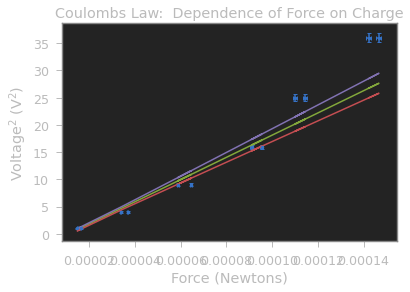

In [14]:
yi = (df3['kV'])**2
xi = df3['Force']
sigmaxi = df3['dForce']
sigmayi = 2.0*yi*(df3['dkV']/df3['kV'])

##############################

from scipy.optimize import curve_fit

def fitfunction(x,*paramlist):
    return paramlist[0]+paramlist[1]*x

init_vals = [0.0 for x in range(2)]
popt, pcov = curve_fit(fitfunction,xi,yi,p0=init_vals,sigma=sigmayi)
perr = np.sqrt(np.diag(pcov))

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([fitfunction(xi,*pi) for pi in ps])

lower = np.percentile(ysample,16.0,axis=0)
upper = np.percentile(ysample,84.0,axis=0)
middle = (lower+upper)/2.0

print("Coefficients (from curve_fit)")
print (popt)
print("Covariance Matrix (from curve_fit)")
print (pcov)

print()
print ("Final Result: Y = (%0.3e +/- %0.3e) X + (%0.9f +/- %0.9f)" % (popt[1],perr[1],popt[0],perr[0]))

plt.errorbar(xi, yi, xerr=sigmaxi, yerr=sigmayi, fmt='.', capsize=2, capthick=1)

plt.plot(xi,middle)
plt.plot(xi,lower)
plt.plot(xi,upper)

#########################
plt.ylabel('Voltage$^2$ (V$^2$)')
plt.xlabel('Force (Newtons)')
plt.title('Coulombs Law:  Dependence of Force on Charge')
plt.show()

In [15]:
#
# Now, let us see if we can calculate what k is, based on the slope from the previous graph
#

slope = popt[1]
dslope = perr[1]

# We know that the slope is supposed to be:  k * (R/R_sphere)^2.
#
#  k = (R_sphere/R)^2*slope
#
# From basic error analysis, we get that (dk/k) = 2dR_sphere/R_sphere + 2dR/R + dslope/slope

R = 0.08
dR = 0.001

k = slope * R_sphere**2/R**2
dk = k*(2*dR/R+2*dR_sphere/R_sphere+dslope/slope)

# NOTE!!!!!  We divide here by 10^3 instead of 10^9 because of the choice above
# to plot in kV, instead of Volts ... there is a factor or 10^6 difference because we are
# plotting V^2.

print ('Extracted value of k = (%0.1f +/- %0.1f) x 10^9 Nm^2/C^2' % (k/1E3,dk/1E3))

Extracted value of k = (11.5 +/- 2.3) x 10^9 Nm^2/C^2


In [16]:
# Finally, let's calculate an error budget.  We would like to understand how much the various uncertainties in the experiment
# contribute to the final error that we get in the extraction of k.

error_budget = [['R_sphere',2*dR_sphere/R_sphere*100],['R',2*dR/R*100],['Slope',dslope/slope*100],['Total',dk/k*100]]
df4 = pd.DataFrame(error_budget, columns = ['Source', 'Percentage Error'])
df4

,Source,Percentage Error
0,R_sphere,10.526316
1,R,2.500000
2,Slope,7.117743
3,Total,20.144059
